In [1]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import string

NAMES_FILE_PATH = os.path.join(os.getcwd(), 'src', 'names.txt')

In [2]:
with open(NAMES_FILE_PATH) as f:
    words = f.read().splitlines()

In [3]:
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
stoi = {s:i for i, s in enumerate(string.ascii_lowercase, 1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
block_size =  3

def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0]  * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]  + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 =  int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff:  {maxdiff}')

In [7]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C =  torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size  * n_embd, n_hidden), generator=g)  * (5/3)/((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g)  * 0.1
W2  = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 =  torch.randn(vocab_size, generator=g) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb,  Yb = Xtr[ix], Ytr[ix]

In [9]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2  
# Cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad  =  None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar,   bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb
          ]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3616, grad_fn=<NegBackward0>)

In [11]:
# Exercise 1: backprop  through the whole thing manually,
# backpropagation through exatly all of the variables
# as tehy are devined in the forward pass about, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
dprobs = (1 / probs) * dlogprobs
dcounts_sum_inv  = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * probs.grad
dcounts_sum = (-1.0*counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum 
dnorm_logits = counts * dcounts
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[-1]) * dlogit_maxes
dh = dlogits @  W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbnraw = (bngain * dhpreact)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0)
dbndiff = dbnraw * bnvar_inv 
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0, keepdim=True)
dhprebn += 1.0/n*dbnmeani * torch.ones_like(hprebn)
dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits',  dlogits, logits)
cmp('h', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bnraw', dbnraw, bnraw)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('dhprebn', dhprebn, hprebn)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhpreact', dhpreact, hpreact)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff:  0.0
probs           | exact: True  | approximate: True  | maxdiff:  0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff:  0.0
counts_sum      | exact: True  | approximate: True  | maxdiff:  0.0
counts          | exact: True  | approximate: True  | maxdiff:  0.0
norm_logits     | exact: True  | approximate: True  | maxdiff:  0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff:  0.0
logits          | exact: True  | approximate: True  | maxdiff:  0.0
h               | exact: True  | approximate: True  | maxdiff:  0.0
dW2             | exact: True  | approximate: True  | maxdiff:  0.0
db2             | exact: True  | approximate: True  | maxdiff:  0.0
hpreact         | exact: True  | approximate: True  | maxdiff:  0.0
bnraw           | exact: True  | approximate: True  | maxdiff:  0.0
bngain          | exact: True  | approximate: True  | maxdiff:  0.0
bnbias          | exact: True  | approximate: Tr

In [13]:
# Exercise 2: backprop  through cross_entropy but all  in  one go 
#  to  ocmplete this  challenge look  anthe  mathematical   expression  of the loss,
#  take the derivative, simplify the expression  and just write it out

# forward  
# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# after
loss_fast =  F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.361618995666504 diff: 0.0


In [15]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /=  n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff:  6.752088665962219e-09


In [18]:
F.softmax(logits, 1)[0]

tensor([0.0688, 0.0947, 0.0203, 0.0497, 0.0194, 0.0829, 0.0279, 0.0346, 0.0166,
        0.0323, 0.0359, 0.0393, 0.0358, 0.0275, 0.0346, 0.0137, 0.0092, 0.0186,
        0.0161, 0.0534, 0.0515, 0.0197, 0.0227, 0.0712, 0.0561, 0.0249, 0.0227],
       grad_fn=<SelectBackward0>)

In [20]:
dlogits[0].sum()

tensor(4.6566e-10, grad_fn=<SumBackward0>)

In [19]:
dlogits[0] * n

tensor([ 0.0688,  0.0947,  0.0203,  0.0497,  0.0194,  0.0829,  0.0279,  0.0346,
        -0.9834,  0.0323,  0.0359,  0.0393,  0.0358,  0.0275,  0.0346,  0.0137,
         0.0092,  0.0186,  0.0161,  0.0534,  0.0515,  0.0197,  0.0227,  0.0712,
         0.0561,  0.0249,  0.0227], grad_fn=<MulBackward0>)

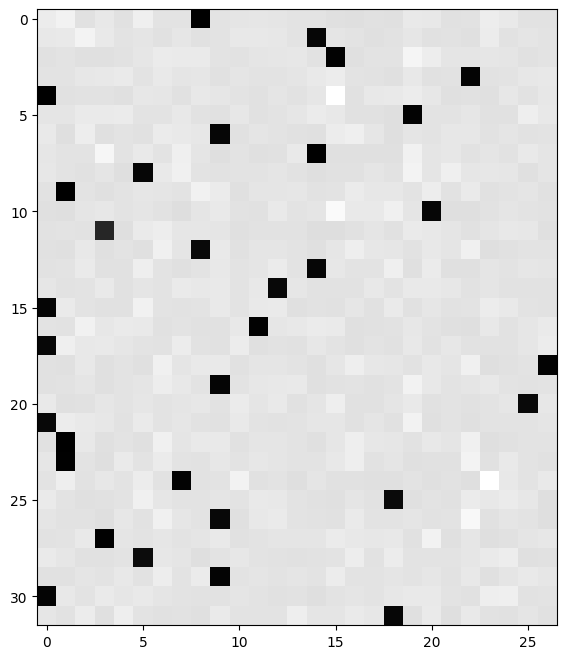

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [25]:
#  Exercise 3: backprop through  batchnorm but all  in  one go
# to complete this challenge look at the mathematical  expression  of the output of batchnorm
# take  the derivative w.r.t  its inpt, simplify  the expression, and  just  write it out

# forward  pass

#  before
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

#  now
hpreact_fast = bngain  * (hprebn - hprebn.mean(0, keepdim=True))  /  torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True)) + bnbias
print(f'max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(3.1471e-05, grad_fn=<MaxBackward1>)


In [28]:
dhprebn =  bngain*bnvar_inv/n *(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('dhprebn', dhprebn, hpreact)

dhprebn         | exact: False | approximate: False | maxdiff:  0.004714179318398237
